In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
#import opendatasets as od

In [24]:
IMAGE_SIZE = 100
BATCH_SIZE = 32
EPOCH = 20

In [25]:
#Loading the Image datasets into tensorflow datasets.
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "DataSet",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 4449 files belonging to 5 classes.


In [26]:
#Class names in tf datasets (Folder Names)
dataset.class_names

['Butterfly', 'Dragonfly', 'Grasshopper', 'Ladybird', 'Mosquito']

In [27]:
len(dataset) #=> Batches count

140

In [28]:
class_names = dataset.class_names

(32, 100, 100, 3)
(32, 100, 100, 3)
(32, 100, 100, 3)
(32, 100, 100, 3)
(32, 100, 100, 3)
(32, 100, 100, 3)
(32, 100, 100, 3)
(32, 100, 100, 3)
(32, 100, 100, 3)
(32, 100, 100, 3)


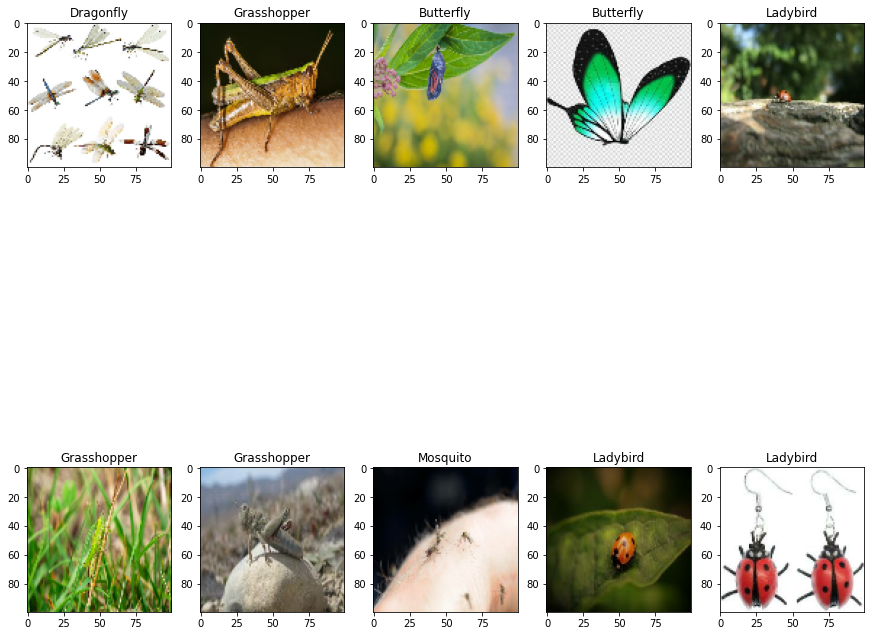

In [29]:
plt.figure(figsize=(15,15))
for image_batch, label_batch in dataset.take(1):
    for i in range(10):
        plt.subplot(2,5, i+1)
        print(image_batch.shape)
#         print(label_batch.numpy())
        plt.title(class_names[label_batch[i]])
        plt.imshow(image_batch[i].numpy().astype("uint8"))

In [30]:
#Test train split
#Train => 80%
#Validation => 10%
#Test => 10%
140*0.8

112.0

In [31]:
def split_dataset(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    
    ds_size=len(ds)
    
    #shuffle if
    if shuffle:
        ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split*ds_size)
    test_size=int(test_split*ds_size)
    val_size=int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    test_ds = ds.skip(train_size).take(test_size)
    val_ds = ds.skip(train_size+test_size)
    
    return train_ds, val_ds, test_ds

In [32]:
train_ds, val_ds, test_ds = split_dataset(dataset)

In [33]:
#Optimisation part.
#Cache -> The processed image will be kept in memory , so if required in
#next iteration, imgs will be loaded faster.
#prefetchine => While GPU is busy training the images, the CPU will load
#the next batch.

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [34]:
val_ds

<PrefetchDataset shapes: ((None, 100, 100, 3), (None,)), types: (tf.float32, tf.int32)>

In [35]:
#Scaling the images from 0 to 255 TO 0 to 1 and creating the layer.

resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [36]:
#Use data augumentation in all rotated view for better prediction at out.
data_aug = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [37]:
#modelling --> CNN for image classification.
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3)

model = models.Sequential([
    resize_rescale,
    data_aug,
    #32 -> layer, (3,3) -> filter size =>CNN layer
    layers.Conv2D(32, (3,3), activation="relu", input_shape=input_shape),#3->channels
    #Pooling Layer
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    
    #Flatten.
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(5, activation="softmax")#5->n_classes
])

model.build(input_shape=input_shape)

In [38]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 100, 100, 3)         0         
                                                                 
 sequential_4 (Sequential)   (32, 100, 100, 3)         0         
                                                                 
 conv2d_5 (Conv2D)           (32, 98, 98, 32)          896       
                                                                 
 max_pooling2d_4 (MaxPooling  (32, 49, 49, 32)         0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (32, 47, 47, 64)          18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (32, 23, 23, 64)         0         
 2D)                                                  

In [39]:
#Model compilation
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [40]:
history = model.fit(train_ds, epochs= EPOCH, batch_size=BATCH_SIZE, verbose=1, validation_data=val_ds)

Epoch 1/20
112/112 [==============================] - 23s 190ms/step - loss: 1.5146 - accuracy: 0.3072 - val_loss: 1.4201 - val_accuracy: 0.4125
Epoch 2/20
112/112 [==============================] - 22s 195ms/step - loss: 1.3498 - accuracy: 0.4104 - val_loss: 1.3153 - val_accuracy: 0.4341
Epoch 3/20
112/112 [==============================] - 21s 184ms/step - loss: 1.2955 - accuracy: 0.4520 - val_loss: 1.3554 - val_accuracy: 0.4293
Epoch 4/20
112/112 [==============================] - 22s 193ms/step - loss: 1.2390 - accuracy: 0.4905 - val_loss: 1.2059 - val_accuracy: 0.4988
Epoch 5/20
112/112 [==============================] - 36s 325ms/step - loss: 1.1882 - accuracy: 0.5165 - val_loss: 1.2394 - val_accuracy: 0.4892
Epoch 6/20
112/112 [==============================] - 36s 319ms/step - loss: 1.1484 - accuracy: 0.5385 - val_loss: 1.2001 - val_accuracy: 0.4916
Epoch 7/20
112/112 [==============================] - 24s 217ms/step - loss: 1.1227 - accuracy: 0.5494 - val_loss: 1.1246 - val_ac

In [41]:
test_scores = model.evaluate(test_ds)
test_scores #[Loss, Accuracy]

14/14 [==============================] - 2s 38ms/step - loss: 0.9749 - accuracy: 0.6362


[0.974920392036438, 0.6361607313156128]

In [42]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 112}

In [43]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [44]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

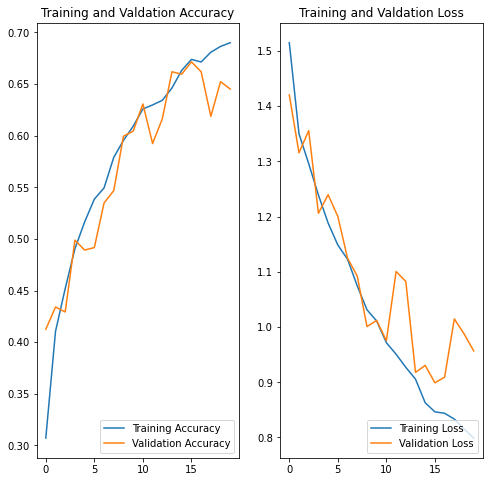

In [45]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCH), acc, label="Training Accuracy")
plt.plot(range(EPOCH), val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Valdation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(range(EPOCH), loss, label="Training Loss")
plt.plot(range(EPOCH), val_loss, label="Validation Loss")
plt.legend(loc="lower right")
plt.title("Training and Valdation Loss")
plt.show()

tf.Tensor(1, shape=(), dtype=int32)
Dragonfly


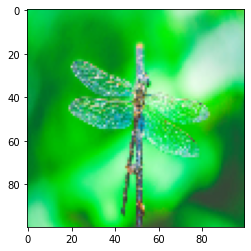

In [46]:
import numpy as np

for images_batch, label_batch in test_ds.take(1):
    plt.imshow(images_batch[0].numpy().astype("uint"))
    print(label_batch[0])

    #predict
    batch_prediction = model.predict(images_batch)
    print(class_names[np.argmax(batch_prediction[0])])

In [47]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) #creates batch
  prediction = model.predict(img_array)
  predicted_class = class_names[np.argmax(prediction[0])]
  confidence = round(100*(np.max(prediction[0])),2)
  return predicted_class, confidence

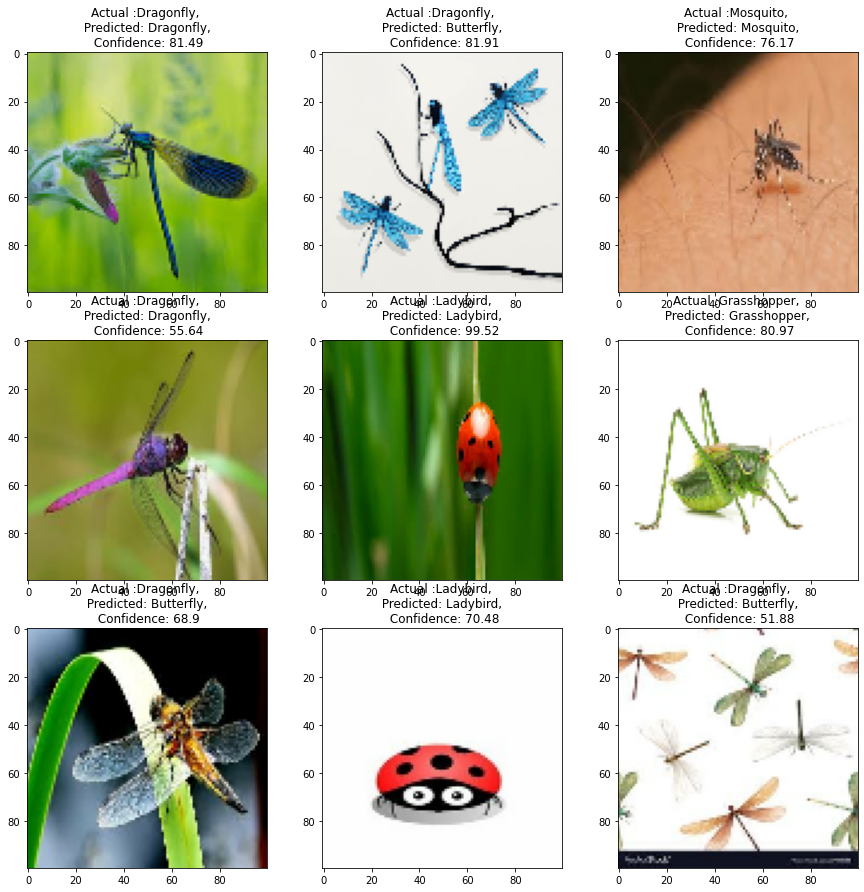

In [50]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1): #Take 1st batch
  for i in range(9): #Choosing first 10 imgs

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.subplot(3,3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f"Actual :{actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}")

In [49]:
model_name = "Initial_Model_89"
model.save(model_name, save_format='h5')